# Atlas: Your Travel Planner

Time for an exciting use case. Now is the time to use all the knowledge we have gathered so far to build a complete AI Agent ourselves.

## Plan of Attack:

1. Import libraries
2. Define our tools
3. Define our tools schema
4. Define a prompt template
5. Call the OpenAI responses
6. Handle tool calls
7. The app logic
8. Gradio Interface
9. Deployment

## Step 1: Import libraries

In [1]:
import os
from tavily import TavilyClient
from dotenv import load_dotenv
import json
from openai import OpenAI
from utils import function_to_tool  # See utils.py for implementation
from IPython.display import display, Markdown
import gradio as gr

load_dotenv()

TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY is not set in the environment variables.")

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY is not set in the environment variables.")

tavily_client = TavilyClient()
openai_client = OpenAI()

c:\Seer\J Notebooks\agentic-ai\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You can setup your API key here: **[Tavily API Key](https://app.tavily.com/home)**

## Step 2: Define our tools

**The tools to define:**

1. Flight Search Tool
2. Hotel Search Tool

In [2]:
query = "I want to travel to Sydney from Auckland on 2025-12-15 and return on 2025-12-25. I prefer budget airlines"

# Make a search request to Tavily with domain filtering. Returns 5 by default. If you don't include domains, it can get results from
# sat facebook or come other site that has no real information on flights.
response = tavily_client.search(
    query=query,
    include_domains=["www.booking.com", "www.skyscanner.net", "www.kayak.com", "www.expedia.com"]
)
# dumps prints the response in a pretty JSON format
print(json.dumps(response, indent=2))

{
  "query": "I want to travel to Sydney from Auckland on 2025-12-15 and return on 2025-12-25. I prefer budget airlines",
  "follow_up_questions": null,
  "answer": null,
  "images": [],
  "results": [
    {
      "title": "$164 Cheap Flights from Sydney (SYD) to Auckland (AKL) Flights for all Top Airlines Around the World - KAYAK $365 Cheap Flights & Airfare to New Zealand - Expedia.com Search Flights, Hotels & Rental Cars | KAYAK",
      "url": "https://www.expedia.com/lp/flights/syd/akl/sydney-to-auckland",
      "content": "Cheap Flights from Sydney (SYD) to Auckland (AKL) start at $164 for one-way and $297 for round trip. Earn your airline miles on top of our rewards! Find great flight deals by looking at some of the most popular flight routes. Get cheap airfare by searching hundreds of travel sites at once with KAYAK . Find cheap return or one-way flights to New Zealand. Book & compare flight deals to New Zealand and save now! Get great flight deals to New Zealand for 2025 . KAYA

In [3]:
# use type hinting and docstrings to create a tool from this function
def flight_search(query: str) -> str:
    """
    Searches for flights based on the provided query

    Args:
        query (str): The search query for flights

    Returns:
        str: A formatted string containing the search results
    
    """

    response = tavily_client.search(
    query=query,
    include_domains=["airnewzealand.com", "qantas.com", "jetstar.com"]
    )

    # get the results node from the response and put it in a list
    results = response.get("results", [])

    # extract items
    contents = [item.get("content", "") for item in results]

    # Format as a numbered list
    formatted_contents = "\n".join(f"{i + 1}. {content}" for i, content in enumerate(contents) if content)

    return formatted_contents

In [4]:
print(flight_search(query))

1. Offer ends: 15 Dec 2025. Price displayed is for 4 nights in a specific room and return Economy Qantas flights departing Sydney. Other departure points may be ...See more
2. Looking for flight deals from Auckland to Sydney? Find available flights, exclusive sales and book your all-inclusive airline ticket!
3. Jetstar sales and special deals. Book cheap flights departing from New Zealand ... 2 - 25 Dec 2025. Sale ends 08:59PM Tuesday 23 December 2025, unless sold out ...See more
4. # Book a flight Search for Qantas flights, and book flights online. When you're ready to book your next Qantas flight, it's easy to redeem your Flight Credit. Redeem your Flight Credit through Manage booking Can I book a flight from or to anywhere? When searching all other Australian domestic flights, you'll be offered a selection of fares for travel in Economy and Business, including when you search for reward flights. For example, if you're browsing from the Australian region, and search for a flight depa

In [5]:
# again use type hinting and docstrings to create a tool from this function
def hotel_search(query: str) -> str:
    """
    Searches for hotels based on the provided query

    Args:
        query (str): The search query for hotels

    Returns:
        str: A formatted string containing the search results
    
    """

    response = tavily_client.search(
    query=query,
    include_domains=["booking.com","airbnb.com", "trivago.com"]
    )

    results = response.get("results", [])

    # step through each item node in the results, and extract the content field. Put it into a list called contents
    contents = [item.get("content", "") for item in results]

    # Now create a formatted string of the contents, numbered as a list from 1 up. 
    # Format as a numbered list. "\n" in this code is the separator between each item in the list - a new line. 
    # enumerate steps through an iterable list but adds the number before each item. the if content at the end removes any empty items.
    # An empty string is considered False in Python.
    formatted_contents = "\n".join(f"{i + 1}. {content}" for i, content in enumerate(contents) if content)

    return formatted_contents

In [6]:
query = "What are some cheap hotels in Sydney?"

print(hotel_search(query))

1. Established in 1816, this waterfront park is home to native and global flora. Wander the Australian Rainforest Garden to see rare palm trees, ferns, and orchids or explore the Calyx, a grand glass complex with a massive living wall. The garden is also home to the city’s largest colony of flying foxes — large, googly-eyed bats who fly around the par... See full list on airbnb . com One of Australia’s finest art collections is housed in a 19th-century building designed to resemble a classical temple of art. There are rich assemblages of Aboriginal and contemporary art alongside paintings by European masters. The gallery hosts exciting traveling exhibitions throughout the year, as well as talks and performances. Best of all, ad... See full list on airbnb . com Explore Australia’s complicated history as a penal colony at this UNESCO World Heritage site , accessible via a short ferry ride. Those sentenced endured harsh conditions on the island, which began operating as a prison in 1839. 

## Step 3: Define our tools schema

In [7]:
# this uses the calgg in utils.py to convert the functions to tool schemas
flight_tool_schema = function_to_tool(flight_search)
hotel_tool_schema = function_to_tool(hotel_search)

In [8]:
hotel_tool_schema

{'type': 'function',
 'name': 'hotel_search',
 'description': 'Searches for hotels based on the provided query',
 'parameters': {'type': 'object',
  'properties': {'query': {'type': 'string',
    'description': 'The search query for hotels'}},
  'required': ['query']}}

## Step 4: Define a Prompt Template

Prompt templates are discussed in our [Prompt Engineering course](https://github.com/SuperDataScience-Community/prompt-engineering) specifically in the notebook for [multi-shot prompting](https://github.com/SuperDataScience-Community/prompt-engineering/blob/main/prompt-engineering-techniques/multi-shot-prompting.ipynb)

In [9]:
# Class to define a prompt template
class PromptTemplate:
    # constructor - pass in the template string and the input variable names as a list
    def __init__(self, template: str, input_variables: list[str]):
        # init instance variables
        self.template = template
        self.input_variables = input_variables
    # then pass in the kwargs to generate the prompt string. ** tells python to package one or more keyword arguments into a dictionary
    def generate(self, **kwargs) -> str:
        # for k in self.input_variables steps through each input_variable name. Then k: kwargs[k] gets the value for that variable from 
        # the kwargs dictionary. So at the end we have {'variable1': value1, 'variable2': value2, ...}. The ** then unpacks that 
        # dictionary into keyword arguments for the format method.
        return self.template.format(**{k: kwargs[k] for k in self.input_variables})

In [10]:
prompt = PromptTemplate(
    template="I want to travel to {destination} from {origin} on {departure_date} and return on {return_date}. I prefer {preferences}",
    input_variables=["destination", "origin", "departure_date", "return_date", "preferences"]
)

In [11]:
prompt.generate(destination="Sydney", origin="Auckland", departure_date="2025-12-15", return_date="2025-12-25", preferences="budget airlines")

'I want to travel to Sydney from Auckland on 2025-12-15 and return on 2025-12-25. I prefer budget airlines'

## Step 5: Call the OpenAI Responses API

In [12]:
# the example flow, output formatting instructions and other instruction for the agent are really important to a good result.
# note also the instruction "Only return the final itinerary—no follow-up questions or conversation needed." LLMs are conversational
# by default so you have to explicitly tell them not to be.
system_message = """
You are an AI travel planner. The user will provide all their vacation details in a single prompt. Your job is to:

1. Use the provided details to search for the best flights and hotels using your tools.
2. Summarize the results in a neatly formatted, easy-to-read itinerary.
3. Do not ask the user any questions or request clarification—just use the information given.
4. Make the itinerary clear, helpful, and a little bit fun!

Example flow:
- Receive the user's vacation details (destination, dates, preferences, etc.).
- Use your flight tool to find the best flight options.
- Use your hotel search tools to find the best options.
- Present a summary itinerary like:

---
**Your Adventure Awaits!**
- Destination: Tokyo, Japan
- Dates: 2024-10-01 to 2024-10-10

✈️ **Flight Options:**
1. [Flight details here]

Day 1:
🏨 **Hotel Options:**
1. [Hotel details here]
2. List of things to do

Day 2:
🏨 **Hotel Options:**
1. [Hotel details here]
2. List of things to do

Day 3:
🏨 **Hotel Options:**
1. [Hotel details here]
2. List of things to do

Have a fantastic trip!
---

Only return the final itinerary—no follow-up questions or conversation needed.
Always call the flight tool first, then the hotel tool. Do not give me a response until you have called both tools.
"""

In [13]:
# user prompt

user_prompt = prompt.generate(
    destination="Sydney",
    origin="Auckland",
    departure_date="2024-10-01",
    return_date="2024-10-10",
    preferences="budget airlines"
)

In [14]:
# input list
input_list = [
    {"role": "system", "content": system_message},
    {"role": "user", "content": user_prompt}
]

In [23]:
# response

response = openai_client.responses.create(
    model="gpt-4",
    input=input_list,
    tools=[flight_tool_schema, hotel_tool_schema],
    tool_choice="auto",
    parallel_tool_calls=False   # make tool calls sequentially. Will cover parallel calls later.
)
# it will either eturns a message or a function call. 
if response.output[0].type == "message":
    # if it is a message, append it to the input list
    input_list.append({"role": "assistant", "content": response.output_text})
if response.output[0].type == "function_call":
    # if it is a function call, extend the input list with the function call details. So now we have the function call details 
    # in the input_list as the third item
    input_list += response.output


In [24]:
# print response
input_list

[{'role': 'system',
  'content': "\nYou are an AI travel planner. The user will provide all their vacation details in a single prompt. Your job is to:\n\n1. Use the provided details to search for the best flights and hotels using your tools.\n2. Summarize the results in a neatly formatted, easy-to-read itinerary.\n3. Do not ask the user any questions or request clarification—just use the information given.\n4. Make the itinerary clear, helpful, and a little bit fun!\n\nExample flow:\n- Receive the user's vacation details (destination, dates, preferences, etc.).\n- Use your flight tool to find the best flight options.\n- Use your hotel search tools to find the best options.\n- Present a summary itinerary like:\n\n---\n**Your Adventure Awaits!**\n- Destination: Tokyo, Japan\n- Dates: 2024-10-01 to 2024-10-10\n\n✈️ **Flight Options:**\n1. [Flight details here]\n\nDay 1:\n🏨 **Hotel Options:**\n1. [Hotel details here]\n2. List of things to do\n\nDay 2:\n🏨 **Hotel Options:**\n1. [Hotel detai

## Step 6: Handle tools calls

In [17]:
# create a function to call the appropriate function based on the name
def call_function(name, args):
    if name == "flight_search":
        return flight_search(**args)
    elif name == "hotel_search":
        return hotel_search(**args)
    else:
        raise ValueError(f"Unknown function: {name}")

In [21]:
# two cells up we got the response - a ResponseFunctionToolCall. Grap the name and arguments from the reponse.
name = response.output[0].name
args = json.loads(response.output[0].arguments) # convert the json string to a dictionary
# call the function, which will call either flight_search or hotel_search based on the name and get the results
result = call_function(name, args)

# now append the function call output to the input list. So we have the function call output as the fourth item in input_list
input_list.append({
    'type': 'function_call_output',
    'call_id': response.output[0].call_id,
    'output': str(result)
})

In [22]:
input_list

[{'role': 'system',
  'content': "\nYou are an AI travel planner. The user will provide all their vacation details in a single prompt. Your job is to:\n\n1. Use the provided details to search for the best flights and hotels using your tools.\n2. Summarize the results in a neatly formatted, easy-to-read itinerary.\n3. Do not ask the user any questions or request clarification—just use the information given.\n4. Make the itinerary clear, helpful, and a little bit fun!\n\nExample flow:\n- Receive the user's vacation details (destination, dates, preferences, etc.).\n- Use your flight tool to find the best flight options.\n- Use your hotel search tools to find the best options.\n- Present a summary itinerary like:\n\n---\n**Your Adventure Awaits!**\n- Destination: Tokyo, Japan\n- Dates: 2024-10-01 to 2024-10-10\n\n✈️ **Flight Options:**\n1. [Flight details here]\n\nDay 1:\n🏨 **Hotel Options:**\n1. [Hotel details here]\n2. List of things to do\n\nDay 2:\n🏨 **Hotel Options:**\n1. [Hotel detai

## Step 7: The App Logic

<div style="border-radius:16px;background:#2e3440;margin:1em 0;padding:1em;color:#eceff4;position:relative;box-shadow:0 6px 16px rgba(0,0,0,.4);overflow-wrap:break-word;word-break:break-word;">
  <b style="color:#88c0d0;font-size:1.25em">Info:</b>
  <span style="display:block;margin-top:.6em;padding-left:1.2em;line-height:1.6">
    In the video lectures, we saw that our Agent, Atlas was not following the example itinerary properly. This is probably due to the smaller sized model we are using. Try replacing that model with <code>gpt-4o</code>, <code>gpt-5</code> or if you want to continue with cheaper models, <code>gpt-4o-mini</code> all of which are great at tool use (with gpt-5 obviously outperforming all models in agentic use cases).
  </span>
  <div style="position:absolute;top:-.8em;left:-.8em;width:2.4em;height:2.4em;border-radius:50%;background:#88c0d0;color:#2e3440;display:flex;align-items:center;justify-content:center;font-weight:700;font-size:1.2em">💡</div>
</div>

In [25]:
def get_response(input_list):
    response = openai_client.responses.create(
        model="gpt-4.1-nano",
        input=input_list,
        tools=[flight_tool_schema, hotel_tool_schema],
        tool_choice="auto",
        parallel_tool_calls=False
    )
    return response

In [26]:
def trip_planner(destination, origin, departure_date, return_date, preferences):

    user_prompt = prompt.generate(
    destination=destination,
    origin=origin,
    departure_date=departure_date,
    return_date=return_date,
    preferences=preferences
    )

    input_list = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt}
    ]

    response = get_response(input_list)

    if response.output[0].type == "function_call":
        while response.output[0].type == "function_call":
            input_list += response.output
            
            name = response.output[0].name
            args = json.loads(response.output[0].arguments)

            result = call_function(name, args)

            input_list.append({
                'type': 'function_call_output',
                'call_id': response.output[0].call_id,
                'output': str(result)
            })

            response = get_response(input_list)

    return response.output_text


In [27]:
display(Markdown(trip_planner("Sydney", "Auckland", "2025-12-15", "2025-12-25", "budget hotels")))

I will now fetch the hotel options for budget accommodations in Sydney from December 15 to December 25, 2025.

## Step 8: Gradio UI

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# Atlas: Your Personal Travel Itinerary Planner")
    gr.Markdown("Plan your perfect trip with ease! Enter your travel details below, and let our AI-powered planner find the best flights and hotels for you.")
    
    with gr.Row():
        destination = gr.Textbox(label="Destination", placeholder="Enter your travel destination (e.g., Tokyo)")
        origin = gr.Textbox(label="Origin", placeholder="Enter your departure city (e.g., New York)")

    with gr.Row():
        departure_date = gr.Textbox(label="Departure Date", placeholder="Enter your departure date (e.g., 2024-10-01)")
        return_date = gr.Textbox(label="Return Date", placeholder="Enter your return date (e.g., 2024-10-10)")

    preferences = gr.Textbox(label="Preferences", placeholder="Enter any preferences (e.g., budget airlines, 4-star hotels)")
    submit_btn = gr.Button("Plan My Trip!")
    output = gr.Markdown(label="Your Itinerary")

    def on_submit(destination, origin, departure_date, return_date, preferences):
        return trip_planner(destination, origin, departure_date, return_date, preferences)
    
    submit_btn.click(on_submit, inputs=[destination, origin, departure_date, return_date, preferences], outputs=output)

demo.launch()

## Step 9: Deployment

You should first get setup on huggingface by making an account:

1. Visit the [huggingface](https://huggingface.co/) website and create an account.
2. Create an [API Key](https://huggingface.co/settings/tokens)
3. Copy the app logic into a `app.py` file and include a `requirements.txt` file inside of `community-contributions/your-name`
4. Open a new terminal
5. Activate our virtual environment
    - Windows command: `.venv\Scripts\activate`
    - Mac/Linux command: `source .venv/bin/activate`
6. cd into part1-fundementals using the command `cd part1-fundementals`
7. Run the command `gradio deploy`
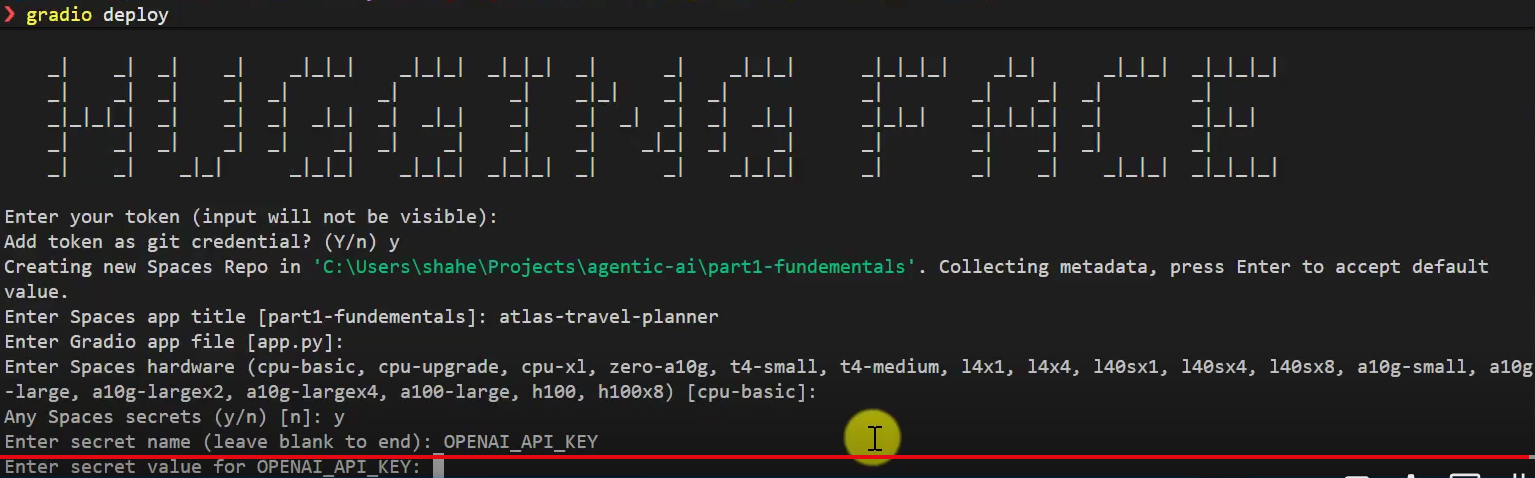
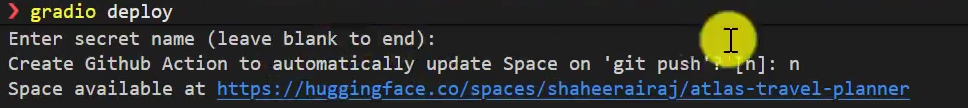
8. Open the link to your deployed app

<div style="border-radius:16px;background:#3b1c1c;margin:1em 0;padding:1em;color:#eceff4;position:relative;box-shadow:0 6px 16px rgba(0,0,0,.4);overflow-wrap:break-word;word-break:break-word;">
  <b style="color:#bf616a;font-size:1.25em">Warning:</b>
  <span style="display:block;margin-top:.6em;padding-left:1.2em;line-height:1.6">
    You must add your <code>app.py</code>, <code>requirements.txt</code>, and a copy of <code>utils.py</code> inside the <code>community-contributions/your-name</code> folder.<br>
    For example: <code>community-contributions/your-name/app.py</code><br>
    Replace <code>your-name</code> with your actual name.
  </span>
  <div style="position:absolute;top:-.8em;left:-.8em;width:2.4em;height:2.4em;border-radius:50%;background:#bf616a;color:#2e3440;display:flex;align-items:center;justify-content:center;font-weight:700;font-size:1.2em">⚠️</div>
</div>